In [1]:
# !pip install matplotlib jaxlib equinox wandb

In [2]:
import os
os.environ["WANDB_API_KEY"] = ""
wandb.init(project="ET")

In [74]:
# Standard imports
import math
from typing import List

# JAX imports
import jax
from jax import numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import jax.random as jr

# Equinox import
import equinox as eqx

# WandB import
import wandb

# Matplotlib import
import matplotlib.pyplot as plt

# Dataclass import
from dataclasses import dataclass


In [75]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [76]:
key = jax.random.PRNGKey(2000)

In [77]:
key, subkey1, subkey2 = jax.random.split(key, 3)

data_set_size = 2_000
data = jnp.concatenate((-0.5 + 0.2 * jax.random.normal(subkey1, (int(data_set_size * 1/5), 2)),
                         0.5 + 0.2 * jax.random.normal(subkey2, (int(data_set_size * 4/5), 2))), axis=0)

print(data.shape)

# Set the number of projections
num_projections = 2

# Generate random projection vectors
key, subkey = jax.random.split(key)
projection_vectors = jax.random.normal(subkey, (num_projections, data.shape[1]))

# Normalize the projection vectors
projection_vectors /= jnp.linalg.norm(projection_vectors, axis=1, keepdims=True)

# Project data onto each random vector
data = [jnp.dot(data, v) for v in projection_vectors]


data = jnp.stack(data, axis=1)

print(data.shape)

(2000, 2)
(2000, 2)


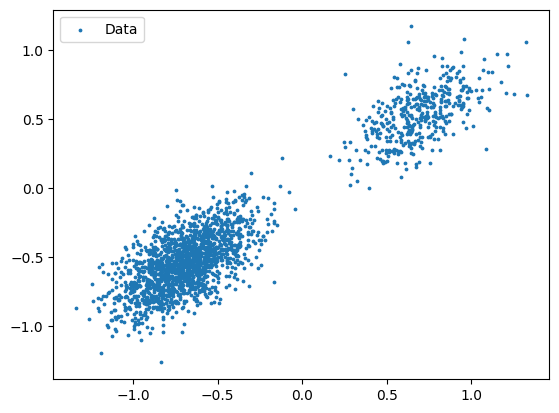

In [78]:
plt.scatter(data[:, 0], data[:, 1], s=3, label="Data")
plt.legend()
plt.show()

## Training


In [79]:
# Source https://github.com/bhoov/energy-transformer-jax

@dataclass
class ETConfig():
  D: int = 2 # Token dimension of ET
  Y: int = 64 # Token dimension of each query and key
  n_heads: int = 12 # Number of heads
  scale_mems: float = 4. # Scale the number of memories by this factor relative to token dimension D

class EnergyLayerNorm(eqx.Module):
  """Define our primary activation function (modified LayerNorm) as a lagrangian with energy"""
  gamma: jax.Array  # Scaling scalar
  delta: jax.Array  # Bias
  use_bias: bool
  eps: float

  def __init__(self, dim: int, use_bias:bool = True, eps:float = 1e-5):
    self.use_bias = use_bias
    self.gamma = jnp.ones(())
    self.delta = jnp.zeros(dim)
    self.eps = eps

  def lagrangian(self, x):
    """The integral of the standard LayerNorm, with the following twist: `gamma` is a scalar, not a vector of shape `dim` as in the original layernorm """
    D = x.shape[-1]
    xmeaned = x - x.mean(-1, keepdims=True)
    t1 = D * self.gamma * jnp.sqrt((1 / D * xmeaned**2).sum() + self.eps)
    if not self.use_bias:
      return t1
    t2 = (self.delta * x).sum()
    return t1 + t2

  def g(self, x):
    """The manual derivative of the lagrangian.

    You could compute this with autograd, but it is more efficient and clear to implement it directly
    """
    xmeaned = x - x.mean(-1, keepdims=True)
    v = self.gamma * (xmeaned) / jnp.sqrt((xmeaned**2).mean(-1, keepdims=True)+ self.eps)
    if self.use_bias:
        return v + self.delta
    return v

  def __call__(self, x):
    """An alias for the activation function `g`"""
    return self.g(x)

  def energy(self, x):
    """Compute the energy of this Lagrangian through the Legendre Transform"""
    return (self.g(x) * x).sum() - self.lagrangian(x)

class EnergyAttention(eqx.Module):
  """Our novel attention with energy

  Has only two learnable parameters, Wk and Wq
  """
  Wq: jax.Array
  Wk: jax.Array
  config: ETConfig = eqx.field(static=True)

  def __init__(self, key:jr.PRNGKey, config:ETConfig):
    kkey, qkey = jr.split(key)
    self.Wk = jr.normal(kkey, (config.n_heads, config.Y, config.D))
    self.Wq = jr.normal(qkey, (config.n_heads, config.Y, config.D))
    self.config = config

  def energy(self, g:jnp.ndarray):
    """Return the energy of the block. The update rule is autograd through this function"""
    beta = 1/jnp.sqrt(self.config.Y)
    K = jnp.einsum("kd,hzd->khz", g, self.Wk) # nKeys,nHeads,Y
    Q = jnp.einsum("qd,hzd->qhz", g, self.Wq) # nQueries,nHeads,Y
    A = jax.nn.logsumexp(beta * jnp.einsum("qhz,khz->hqk", Q, K), -1) # nHeads,nQueries,nKeys
    return -1/beta * A.sum()

class HopfieldNetwork(eqx.Module):
  """ A simple Hopfield Network (we use ReLU as the activation function) replaces the MLP in traditional Transformers """
  Xi: jax.Array

  def __init__(self, key:jr.PRNGKey, config:ETConfig):
    nmems = int(config.scale_mems * config.D)
    self.Xi = jr.normal(key, (config.D, nmems))

  def energy(self, g:jnp.ndarray):
    """Return the Hopfield Network's energy"""
    hid = jnp.einsum("nd,dm->nm", g, self.Xi) # nTokens, nMems
    E = -0.5 * (jax.nn.relu(hid) ** 2).sum()
    return E

class EnergyTransformer(eqx.Module):
  """A simple wrapper class that sums the energies of the Hopfield Network and the Attention"""
  attn: EnergyAttention
  hn: HopfieldNetwork
  config: ETConfig = eqx.field(static=True)

  def __init__(self, key:jr.PRNGKey, config:ETConfig):
    attn_key, hn_key = jr.split(key)
    self.attn = EnergyAttention(attn_key, config)
    self.hn = HopfieldNetwork(hn_key, config)
    self.config = config

  def energy(self, g:jnp.ndarray):
    """Return the energy of the whole Transformer"""
    return self.attn.energy(g) + self.hn.energy(g)


In [80]:
config = ETConfig()
et = EnergyTransformer(key, config)
lnorm = EnergyLayerNorm(config.D, use_bias=False)

def energy(x):
  E1 = lnorm.energy(x)
  g = lnorm.g(x)
  E2 = et.energy(g)
  return E1 + E2

x = data
nsteps = 500
alpha = 0.01

get_energy = jax.jit(jax.value_and_grad(energy))
xmins = []
xmaxes = []
gdiff = None

gprev = None
for i in range(nsteps):
  g = lnorm(x)
  if gprev is not None:
    gdiff = jnp.max(jnp.abs(g - gprev))

  gprev = g
  E, dEdg = get_energy(g)
  x = x - alpha * dEdg

  wandb.log({"Xmax": jnp.max(x), "Xmin": jnp.min(x), "Energy": E, "gdiff": gdiff })


In [81]:
def ebm(x):
    g = et.energy(jnp.array([x]))
    #scalar = jnp.sum(g)
    #scalar = jnp.mean(g)
    return g


## Plotting the training history

In [82]:
def get_energy_map(model, density=100, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(model, in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(100, 100)
    return X, Y, Z

def get_score_map(model, density=30, val=1.6):
    xs = jnp.linspace(-val, val, density)
    ys = jnp.linspace(-val, val, density)
    X, Y = jnp.meshgrid(xs, ys)
    XY = jnp.stack([X, Y], axis=-1)
    XY = XY.reshape(-1, 2)
    f_vectorized = jax.vmap(jax.grad(lambda x: -1 * model(x)), in_axes=(0))
    Z = f_vectorized(XY)
    Z = Z.reshape(density, density, 2)

    return X, Y, Z

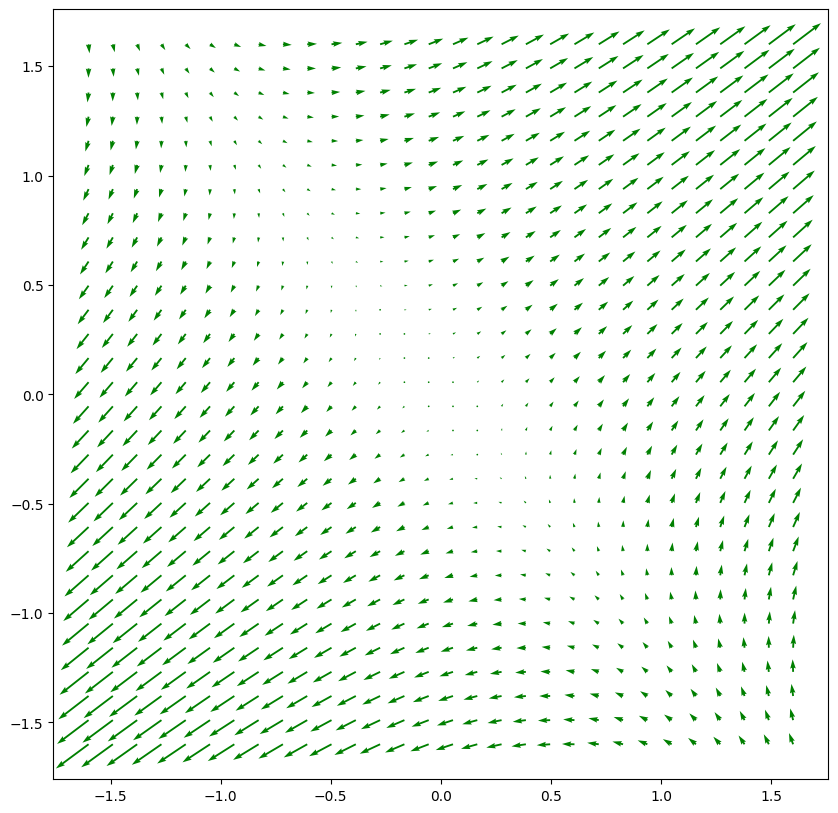

In [83]:
X, Y, Z = get_score_map(ebm)

plt.figure(figsize=(10, 10))
plt.quiver(X, Y, Z[:,:,0], Z[:,:,1], color='g')
plt.show()

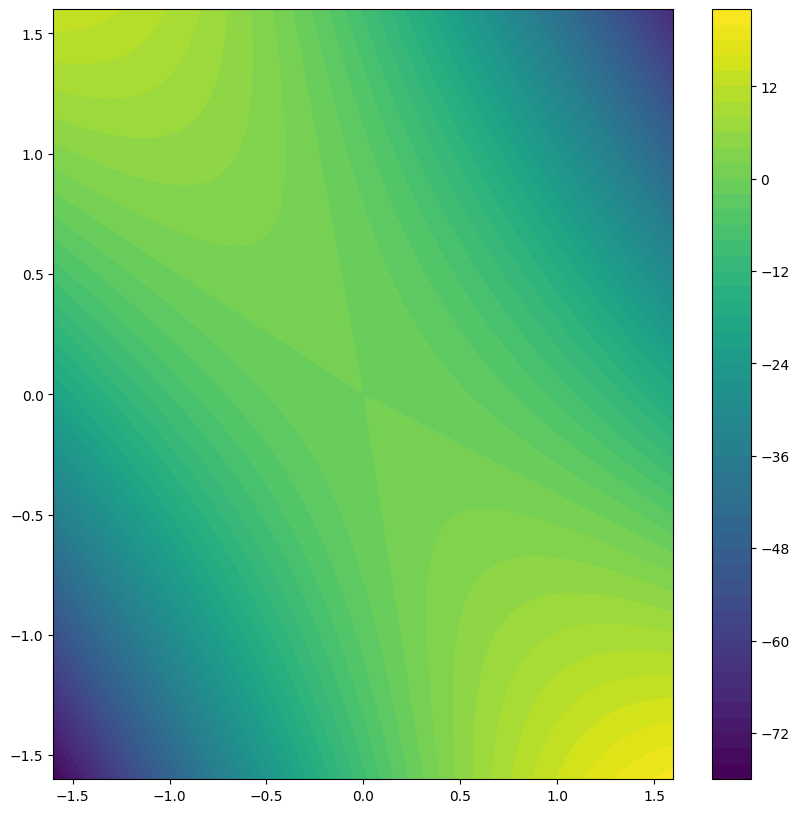

In [84]:
X, Y, Z = get_energy_map(ebm)

plt.figure(figsize=(10, 10))
plt.contourf(X, Y, Z, 50, cmap='viridis')
plt.colorbar()
plt.show()